In [1]:
from __future__ import division

import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

from glob import glob
import os

import numpy as np
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))


In [3]:
from embeddings import *

# retrieve sketch paths
def list_files(path, ext='png'):
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

In [4]:
sketch_dir_data = '/data/jefan/graphical_conventions/sketches'
feat_dir_data = '/data/jefan/graphical_conventions/features'

In [5]:
fpaths = [os.path.join(sketch_dir_data,i) for i in os.listdir(sketch_dir_data)]

In [6]:
from PIL import Image
import pandas as pd

In [7]:
import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')


In [9]:
## scikit learn
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [22]:
F = np.load(os.path.join(feat_dir_data,'no_crop','FEATURES_FC6_sketch.npy'))
M = pd.read_csv(os.path.join(feat_dir_data,'no_crop','METADATA_sketch.csv'))

In [31]:
## define PCA variants
pca1000 = PCA(n_components=1000)
pca512 = PCA(n_components=512)
pca300 = PCA(n_components=300)
pca50 = PCA(n_components=50)

In [24]:
## fit pca1000 to dataset and transform
pca1000.fit(F)
F_ = pca1000.fit_transform(F)

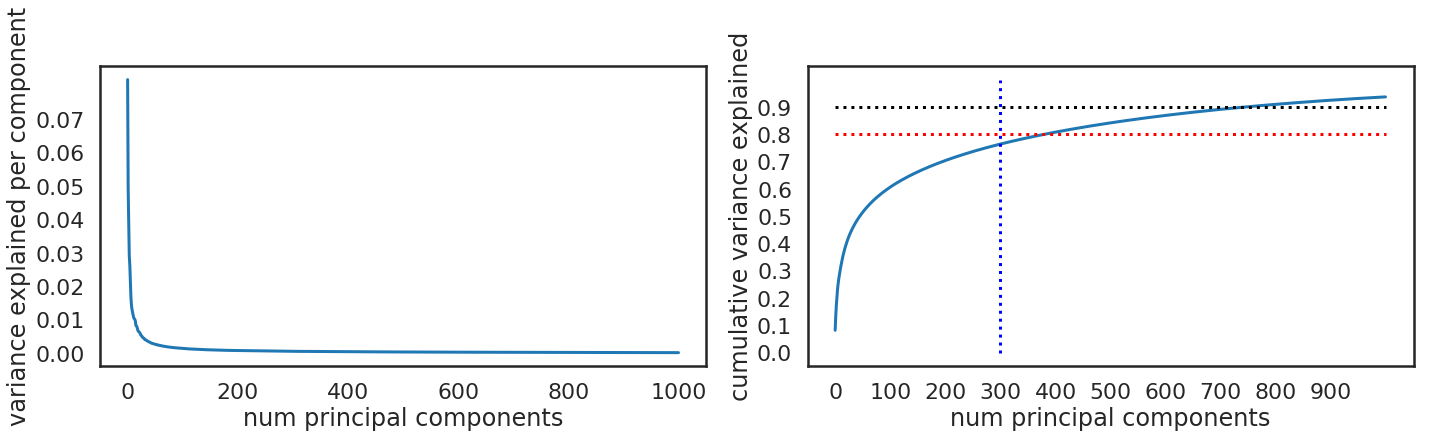

In [25]:
## visualize variance explained by different components
fig = plt.figure(figsize=(20,6))
plt.subplot(121)
h = plt.plot(pca1000.explained_variance_ratio_)
t = plt.yticks(np.arange(0, 0.08, step=0.01))
l = plt.ylabel('variance explained per component')
l = plt.xlabel('num principal components')
plt.subplot(122)
cs = np.cumsum(pca1000.explained_variance_ratio_)
h = plt.plot(cs)
t = plt.yticks(np.arange(0, 1, step=0.1))
t = plt.xticks(np.arange(0, 1000, step=100))
l = plt.ylabel('cumulative variance explained')
l = plt.xlabel('num principal components')
plt.plot((0,1000),(0.9,0.9),'k:')
plt.plot((0,1000),(0.8,0.8),'r:')
plt.plot((300,300),(0,1.),'b:')
plt.tight_layout()

In [32]:
## okay, slightly >300 seems pretty good!

## fit pca300 to dataset and transform
pca512.fit(F)
F_ = pca512.fit_transform(F)

In [35]:
## save out feats
out_path_pca = os.path.join(feat_dir_data,'no_crop','FEATURES_FC6_sketch_PCA_512.npy')
np.save(out_path_pca,F_)

In [36]:
np.savetxt(os.path.join(feat_dir_data,'no_crop','FEATURES_FC6_sketch_PCA_512.txt'), F_, delimiter=',') 

In [43]:
## fit pca300 to dataset and transform
pca128 = PCA(n_components=128)
pca128.fit(F)
F_ = pca128.fit_transform(F)

In [46]:
mat = np.corrcoef(F_.T)

In [50]:
np.round(mat,3)

array([[ 1., -0., -0., ..., -0., -0., -0.],
       [-0.,  1., -0., ...,  0.,  0., -0.],
       [-0., -0.,  1., ..., -0., -0.,  0.],
       ...,
       [-0.,  0., -0., ...,  1., -0.,  0.],
       [-0.,  0., -0., ..., -0.,  1., -0.],
       [-0., -0.,  0., ...,  0., -0.,  1.]])

In [51]:
F_.std(0)

array([18.115282 , 14.00876  , 12.344731 , 10.809932 , 10.250978 ,
        9.223537 ,  8.180019 ,  7.5345993,  7.2132783,  6.977982 ,
        6.692449 ,  6.511423 ,  6.419504 ,  6.357526 ,  6.1899633,
        5.746806 ,  5.691208 ,  5.6009007,  5.338513 ,  5.1435924,
        5.060529 ,  5.022887 ,  4.929267 ,  4.809417 ,  4.6216693,
        4.5655603,  4.4819903,  4.341067 ,  4.2787805,  4.2077894,
        4.171182 ,  4.0213447,  3.9943194,  3.9338531,  3.919863 ,
        3.8688903,  3.780978 ,  3.7352228,  3.6833606,  3.6440945,
        3.6070962,  3.5643718,  3.5146337,  3.4677706,  3.4083416,
        3.3895326,  3.3682888,  3.329979 ,  3.3062956,  3.2622054,
        3.2479718,  3.2050707,  3.1710334,  3.1611567,  3.1500695,
        3.0820587,  3.0571144,  3.0544877,  3.0173101,  2.9967337,
        2.9831614,  2.959537 ,  2.9281416,  2.902877 ,  2.8767726,
        2.860815 ,  2.8434541,  2.8391964,  2.812867 ,  2.8012595,
        2.7688544,  2.7428634,  2.7264645,  2.694637 ,  2.6913